In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Charger les données
data = pd.read_csv('friday.csv')

# Afficher un aperçu des données
print(data.head())


   Src IP dec  Src Port  Dst IP dec  Dst Port  Protocol Timestamp  \
0  3232238130     56108  3232238083      3268         6   59:50.3   
1  3232238130     42144  3232238083       389         6   59:50.3   
2   134610945         0   134219268         0         0   00:31.4   
3  3232238105      5353  3758096635      5353        17   00:42.9   
4  3232238105       123   301796989       123        17   00:42.4   

   Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      112740690                32                 16   
1      112740560                32                 16   
2      113757377               545                  0   
3       91997219               388                  0   
4       66966070                 6                  6   

   Total Length of Fwd Packet  ...  Active Min    Idle Mean      Idle Std  \
0                        6448  ...         343  16105402.14  4.988048e+05   
1                        6448  ...         285  16105427.43  4.987937e+05   
2          

In [2]:
# Nettoyer et prétraiter les données
data.fillna(0, inplace=True)
data['Label'] = data['Label'].apply(lambda x: 'Normal' if x == 0 else 'Threat')

# Extraire des colonnes spécifiques pour la modélisation
network_data = data[['Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Flow Bytes/s', 'Flow Packets/s', 'Label']]
print(network_data.head())


   Total Fwd Packet  Total Bwd packets  Total Length of Fwd Packet  \
0                32                 16                        6448   
1                32                 16                        6448   
2               545                  0                           0   
3               388                  0                       37151   
4                 6                  6                         288   

   Total Length of Bwd Packet  Flow Bytes/s  Flow Packets/s   Label  
0                        1152     67.411331        0.425756  Threat  
1                        5056    102.039585        0.425756  Threat  
2                           0      0.000000        4.790898  Threat  
3                           0    403.827424        4.217519  Threat  
4                         288      8.601371        0.179195  Threat  


In [3]:
class DiffusionModel:
    def __init__(self, graph):
        self.graph = graph

    def simulate_diffusion(self, seed_nodes, steps=10):
        infected = set(seed_nodes)
        new_infected = set(seed_nodes)

        for _ in range(steps):
            next_infected = set()
            for node in new_infected:
                # Check if node is in the graph before accessing its neighbors
                if node in self.graph:
                    neighbors = set(self.graph.neighbors(node))
                    next_infected.update(neighbors - infected)
                else:
                    print(f"Node {node} is not in the graph.")
            infected.update(next_infected)
            new_infected = next_infected
        return infected


# Créer un graphe réseau à partir des données
G = nx.from_pandas_edgelist(network_data, source='Total Fwd Packet', target='Total Bwd packets')

# Initialiser le modèle de diffusion
diffusion_model = DiffusionModel(G)

# Simuler la diffusion
infected_nodes = diffusion_model.simulate_diffusion(seed_nodes=[network_data.index[0]])
print(f'Noeuds infectés après la diffusion: {infected_nodes}')


Noeuds infectés après la diffusion: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

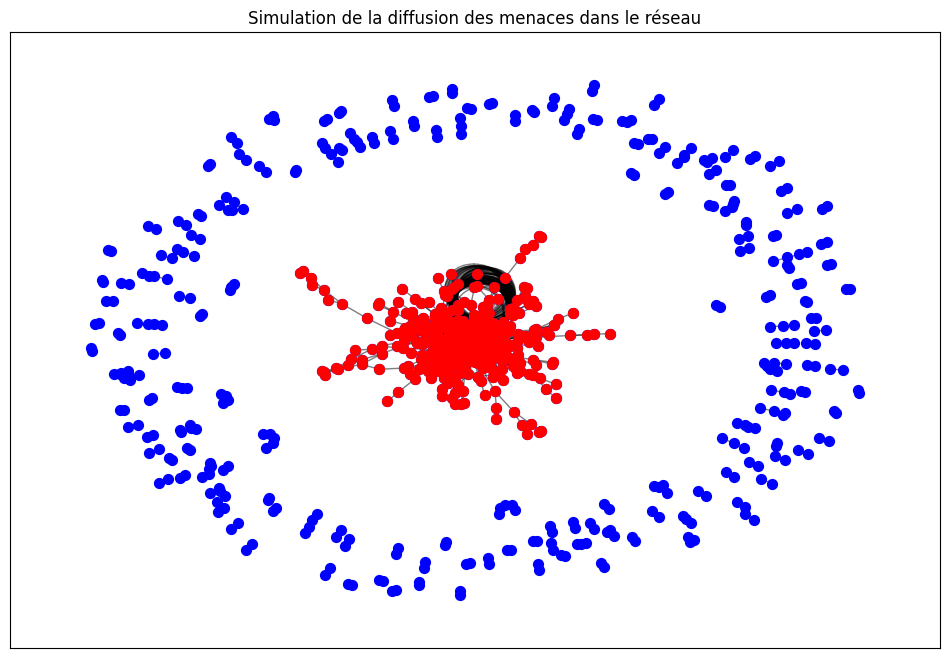

In [4]:
# Visualiser le graphe et la diffusion
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5)

infected_subgraph = G.subgraph(infected_nodes)
nx.draw_networkx_nodes(infected_subgraph, pos, node_color='red', node_size=50)

plt.title('Simulation de la diffusion des menaces dans le réseau')
plt.show()


In [5]:
# Importer les bibliothèques nécessaires
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Extraire les caractéristiques et les labels
features = data[['Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Flow Bytes/s', 'Flow Packets/s']]
labels = data['Label'].apply(lambda x: 1 if x == 'Threat' else 0)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Entraîner le modèle de classification
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Prédire les labels pour l'ensemble de test
y_pred = classifier.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


              precision    recall  f1-score   support

           1       1.00      1.00      1.00    164268

    accuracy                           1.00    164268
   macro avg       1.00      1.00      1.00    164268
weighted avg       1.00      1.00      1.00    164268

Accuracy: 1.0


In [6]:
class DiffusionModelWithClassification:
    def __init__(self, graph, classifier):
        self.graph = graph
        self.classifier = classifier

    def simulate_diffusion(self, seed_nodes, steps=10):
        infected = set(seed_nodes)
        new_infected = set(seed_nodes)
        
        for _ in range(steps):
            next_infected = set()
            for node in new_infected:
                neighbors = set(self.graph.neighbors(node))
                next_infected.update(neighbors - infected)
            infected.update(next_infected)
            new_infected = next_infected
        return infected

    def classify_nodes(self, node_features):
        return self.classifier.predict(node_features)

# Créer le modèle de diffusion avec classification
diffusion_model = DiffusionModelWithClassification(G, classifier)

# Simuler la diffusion
infected_nodes = diffusion_model.simulate_diffusion(seed_nodes=[network_data.index[0]])

# Convertir infected_nodes en liste
infected_nodes_list = list(infected_nodes)

# Extraire les caractéristiques des nœuds infectés pour la classification
infected_features = network_data.loc[infected_nodes_list, ['Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Flow Bytes/s', 'Flow Packets/s']]

# Classifier les nœuds infectés
node_labels = diffusion_model.classify_nodes(infected_features)

# Ajouter les résultats de la classification au dataframe
network_data.loc[infected_nodes_list, 'classification'] = node_labels
network_data['classification'] = network_data['classification'].apply(lambda x: 'Threat' if x == 1 else 'Normal')

print(network_data.head())


C:\Users\Elite_Book\AppData\Local\Temp\ipykernel_8812\4189686480.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_data.loc[infected_nodes_list, 'classification'] = node_labels


   Total Fwd Packet  Total Bwd packets  Total Length of Fwd Packet  \
0                32                 16                        6448   
1                32                 16                        6448   
2               545                  0                           0   
3               388                  0                       37151   
4                 6                  6                         288   

   Total Length of Bwd Packet  Flow Bytes/s  Flow Packets/s   Label  \
0                        1152     67.411331        0.425756  Threat   
1                        5056    102.039585        0.425756  Threat   
2                           0      0.000000        4.790898  Threat   
3                           0    403.827424        4.217519  Threat   
4                         288      8.601371        0.179195  Threat   

  classification  
0         Threat  
1         Threat  
2         Threat  
3         Threat  
4         Threat  


C:\Users\Elite_Book\AppData\Local\Temp\ipykernel_8812\4189686480.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_data['classification'] = network_data['classification'].apply(lambda x: 'Threat' if x == 1 else 'Normal')


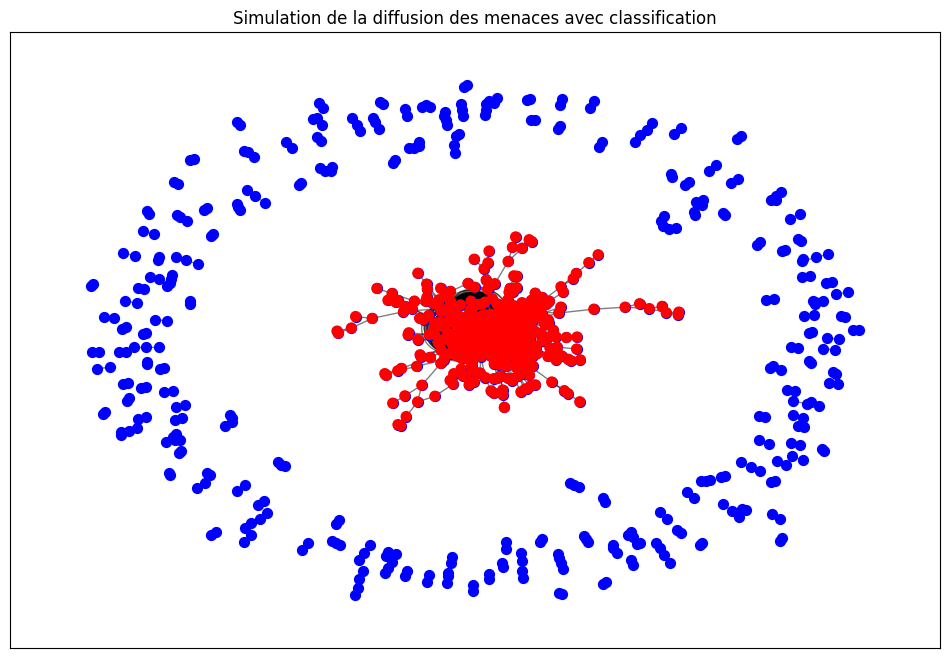

In [7]:
# Affichage du graphe et diffusion avec classification
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Colorier les nœuds infectés en fonction de leur classification
infected_colors = ['red' if label == 'Threat' else 'green' for label in network_data.loc[infected_nodes_list, 'classification']]
nx.draw_networkx_nodes(G, pos, nodelist=infected_nodes_list, node_color=infected_colors, node_size=50)

plt.title('Simulation de la diffusion des menaces avec classification')
plt.show()
